BONUS: We explored the classification problem of identifying extreme rainfall patterns. We seperated the data set into the following three groups: days that had extreme rainfall, normal rainfall and no rainfall. During the analysis, we succeeded in finding certain patterns in the rainfall from the previous days with a degree of correlation to the day after. We used this to create clusters which enriched the features on which a Naive Bayes model was run and met with reasonable success.

In [41]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
import os
import pandas as pd
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 6, 3
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.cluster import KMeans
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
def init_spark(app_name: str):
    spark = SparkSession.builder.appName(app_name).getOrCreate()
    sc = spark.sparkContext
    return spark, sc

# # To dynamically enable Kafka package we can set an environment variable:
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages=org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.1," \
                             "com.microsoft.azure:spark-mssql-connector_2.12:1.1.0 pyspark-shell"
username = "arieln"
password = "Qwerty12!"
server_name = "jdbc:sqlserver://technionddscourse.database.windows.net:1433"
database_name = "arieln"
url = server_name + ";" + "databaseName=" + database_name + ";"

In [4]:
spark, sc = init_spark('bonus')

Create data set by joining two dataframes created in the database

In [115]:
time_df = spark.read \
        .format("com.microsoft.sqlserver.jdbc.spark") \
        .option("url", url) \
        .option("dbtable", "timeDF") \
        .option("user", username) \
        .option("password", password).load()
spatial_df = spark.read \
        .format("com.microsoft.sqlserver.jdbc.spark") \
        .option("url", url) \
        .option("dbtable", "spatialDF") \
        .option("user", username) \
        .option("password", password).load()

In [117]:
raw_model_df = time_df.join(spatial_df, on="StationId")

In [108]:
raw_model_df.show(5)

+-----------+----------+-----+--------+---------+------------------+------------------+------------------+-------------+
|  StationId|      Date|label|latitude|longitude|           maxTemp|           minTemp|           avgPrcp|cluster_label|
+-----------+----------+-----+--------+---------+------------------+------------------+------------------+-------------+
|GME00126586|2016-02-17|    0| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|
|GME00126586|2016-01-11|  160| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|
|GME00126586|2016-08-19|    2| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|
|GME00126586|2016-06-30|    0| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|
|GME00126586|2016-03-16|    0| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|
+-----------+----------+-----+--

In [118]:
raw_model_df.createOrReplaceTempView("temp")
with_lag  = spark.sql("SELECT *, Lag(label, 1) OVER w one_PRCP, " + 
                        "Lag(label, 2) OVER w two_PRCP, Lag(label, 3) OVER w three_PRCP " +
                        "FROM temp " + 
                        "WINDOW w AS (PARTITION BY StationId ORDER BY date ASC)")

In [109]:
with_lag.show(5)

+-----------+----------+-----+--------+---------+------------------+------------------+------------------+-------------+--------+--------+----------+
|  StationId|      Date|label|latitude|longitude|           maxTemp|           minTemp|           avgPrcp|cluster_label|one_PRCP|two_PRCP|three_PRCP|
+-----------+----------+-----+--------+---------+------------------+------------------+------------------+-------------+--------+--------+----------+
|GME00126586|2016-01-01|    5| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|    null|    null|      null|
|GME00126586|2016-01-02|   39| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|       5|    null|      null|
|GME00126586|2016-01-03|  101| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|      39|       5|      null|
|GME00126586|2016-01-04|   41| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.6668497285

As can be seen, the lags at the beginning of each station have null values. Let us remove those rows

In [119]:
no_null_lags = with_lag.filter(F.col("three_PRCP").isNotNull())

In [110]:
no_null_lags.show(5)

+-----------+----------+-----+--------+---------+------------------+------------------+------------------+-------------+--------+--------+----------+
|  StationId|      Date|label|latitude|longitude|           maxTemp|           minTemp|           avgPrcp|cluster_label|one_PRCP|two_PRCP|three_PRCP|
+-----------+----------+-----+--------+---------+------------------+------------------+------------------+-------------+--------+--------+----------+
|GME00126586|2016-01-04|   41| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|     101|      39|         5|
|GME00126586|2016-01-05|   78| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|      41|     101|        39|
|GME00126586|2016-01-06|   10| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|      78|      41|       101|
|GME00126586|2016-01-07|   57| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.6668497285

Let us define extreme rainfall as two standard deviations above the average

In [12]:
average_rainfall = raw_model_df.agg(F.avg(F.col("label")))
average_rainfall.show()

+-----------------+
|       avg(label)|
+-----------------+
|21.31476127094895|
+-----------------+



In [13]:
std_rainfall = raw_model_df.agg(F.stddev(F.col("label")))
std_rainfall.show()

+------------------+
|stddev_samp(label)|
+------------------+
| 54.51445647336993|
+------------------+



In [14]:
extreme_value = 20.28 + 2*50.31
extreme_value

120.9

In [120]:
classified_df = no_null_lags.withColumn("class_label", F.when(F.col("label") >= 120.9, 2).when(F.col("label") == 0, 0).otherwise(1))

In [111]:
classified_df.show(5)

+-----------+----------+-----+--------+---------+------------------+------------------+------------------+-------------+--------+--------+----------+-----------+
|  StationId|      Date|label|latitude|longitude|           maxTemp|           minTemp|           avgPrcp|cluster_label|one_PRCP|two_PRCP|three_PRCP|class_label|
+-----------+----------+-----+--------+---------+------------------+------------------+------------------+-------------+--------+--------+----------+-----------+
|GME00126586|2016-01-04|   41| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|     101|      39|         5|          1|
|GME00126586|2016-01-05|   78| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|      41|     101|        39|          1|
|GME00126586|2016-01-06|   10| 49.3444|   7.2303|287.96938775510205|-34.87755102040816|23.666849728520816|            1|      78|      41|       101|          1|
|GME00126586|2016-01-07|   5

Let us take a random sample of stations in order to get an idea of the data in pandas and seaborn, which makes the data analysis easier and more descriptive. We will note that this analysis was performed twice on different sets of stations drawn from each classification group and the results were similar both times.

In [17]:
class2_df = classified_df.filter(F.col("class_label") == 2)
class1_df = classified_df.filter(F.col("class_label") == 1)
class0_df = classified_df.filter(F.col("class_label") == 0)

In [18]:
class2_sample = random.sample(class2_df.select("StationId").distinct().toPandas()["StationId"].tolist(), 50)
class1_sample = random.sample(class1_df.select("StationId").distinct().toPandas()["StationId"].tolist(), 50)
class0_sample = random.sample(class0_df.select("StationId").distinct().toPandas()["StationId"].tolist(), 50)

In [19]:
only_extreme_df = class2_df.filter(F.col("StationId").isin(class2_sample)).toPandas()
not_extreme_df = class1_df.filter(F.col("StationId").isin(class1_sample)).toPandas()
no_rain_df = class0_df.filter(F.col("StationId").isin(class0_sample)).toPandas()

Below we see that the biggest noticable difference is in the categories one_PRCP, two_PRCP, three_PRCP. Which have a clear order (from highest to lowest) extreme, normal, no rain. Meaning that there seems to be some sort of continuety between the previous days rains and todays rain. Also the STD follows the same order, meaning that it will probably be more straight forward to predict no rain, rather than either of the other two categories.

In [21]:
only_extreme_df.describe()

,label,latitude,longitude,maxTemp,minTemp,avgPrcp,cluster_label,one_PRCP,two_PRCP,three_PRCP,class_label
count,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.0
mean,209.210746,49.909203,7.943180,259.564847,-39.131196,25.396976,1.107739,61.454065,37.727728,29.536748,2.0
std,115.322295,4.711539,4.751384,35.393721,33.725471,11.782041,0.541588,111.488312,76.079202,63.824044,0.0
min,121.000000,27.922501,-15.389200,185.161616,-110.938144,2.578968,0.000000,0.000000,0.000000,0.000000,2.0
25%,141.000000,47.835602,5.555300,237.556701,-56.421053,17.089860,1.000000,0.000000,0.000000,0.000000,2.0
50%,171.000000,49.666901,9.765600,267.048077,-43.642105,20.507869,1.000000,20.000000,4.000000,1.000000,2.0
75%,237.000000,52.405602,11.598075,280.915789,-21.445545,27.324579,1.000000,78.000000,44.000000,30.000000,2.0
max,2209.000000,60.388302,13.841900,348.754545,151.288889,50.662624,2.000000,2209.000000,1212.000000,1212.000000,2.0


In [22]:
not_extreme_df.describe()

,label,latitude,longitude,maxTemp,minTemp,avgPrcp,cluster_label,one_PRCP,two_PRCP,three_PRCP,class_label
count,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.000000,35104.0
mean,28.443910,52.324413,6.593767,256.521359,-32.893669,25.030767,1.208637,33.567542,29.564551,28.463110,1.0
std,29.868983,6.637167,6.702120,44.322090,37.852653,14.060832,0.667747,64.685712,60.373006,60.756454,0.0
min,1.000000,37.844200,-7.903100,91.562500,-143.104167,7.823521,0.000000,0.000000,0.000000,0.000000,1.0
25%,5.000000,48.784199,0.856400,213.063830,-45.468750,15.904174,1.000000,0.000000,0.000000,0.000000,1.0
50%,17.000000,51.310299,8.240000,273.894737,-29.163462,19.094061,1.000000,7.000000,4.000000,2.000000,1.0
75%,44.000000,54.669998,12.131700,283.029126,-12.684211,28.174298,2.000000,40.000000,33.000000,30.000000,1.0
max,120.000000,69.977501,23.358101,382.606838,50.807018,73.952735,2.000000,1584.000000,1584.000000,1234.000000,1.0


In [23]:
no_rain_df.describe()

,label,latitude,longitude,maxTemp,minTemp,avgPrcp,cluster_label,one_PRCP,two_PRCP,three_PRCP,class_label
count,47064.0,47064.000000,47064.000000,47064.000000,47064.000000,47064.000000,47064.000000,47064.000000,47064.000000,47064.000000,47064.0
mean,0.0,48.050194,5.442875,265.056113,-28.192422,21.367718,0.928565,9.748215,15.378612,17.213624,0.0
std,0.0,5.582343,6.271726,45.996140,40.322182,9.077940,0.588254,35.175853,47.811215,50.755128,0.0
min,0.0,36.015301,-6.216000,112.277778,-101.981481,10.327078,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.0,42.770000,0.884200,249.680000,-52.680000,14.379455,1.000000,0.000000,0.000000,0.000000,0.0
50%,0.0,50.291698,8.410000,270.275510,-31.307692,19.616227,1.000000,0.000000,0.000000,0.000000,0.0
75%,0.0,51.867802,10.363300,287.190000,-14.231579,24.551661,1.000000,2.000000,6.000000,9.000000,0.0
max,0.0,59.855801,13.561700,353.091743,89.491071,61.363532,2.000000,968.000000,1103.000000,1310.000000,0.0


Therefore, we will now explore the lags

The distribution of each of the lags is similar; as expected.

In [24]:
df_list = [only_extreme_df, not_extreme_df, no_rain_df]
df_names = ["extreme", "normal", "no rain"]
prcp_list = ["one_PRCP", "two_PRCP", "three_PRCP"]

one_PRCP


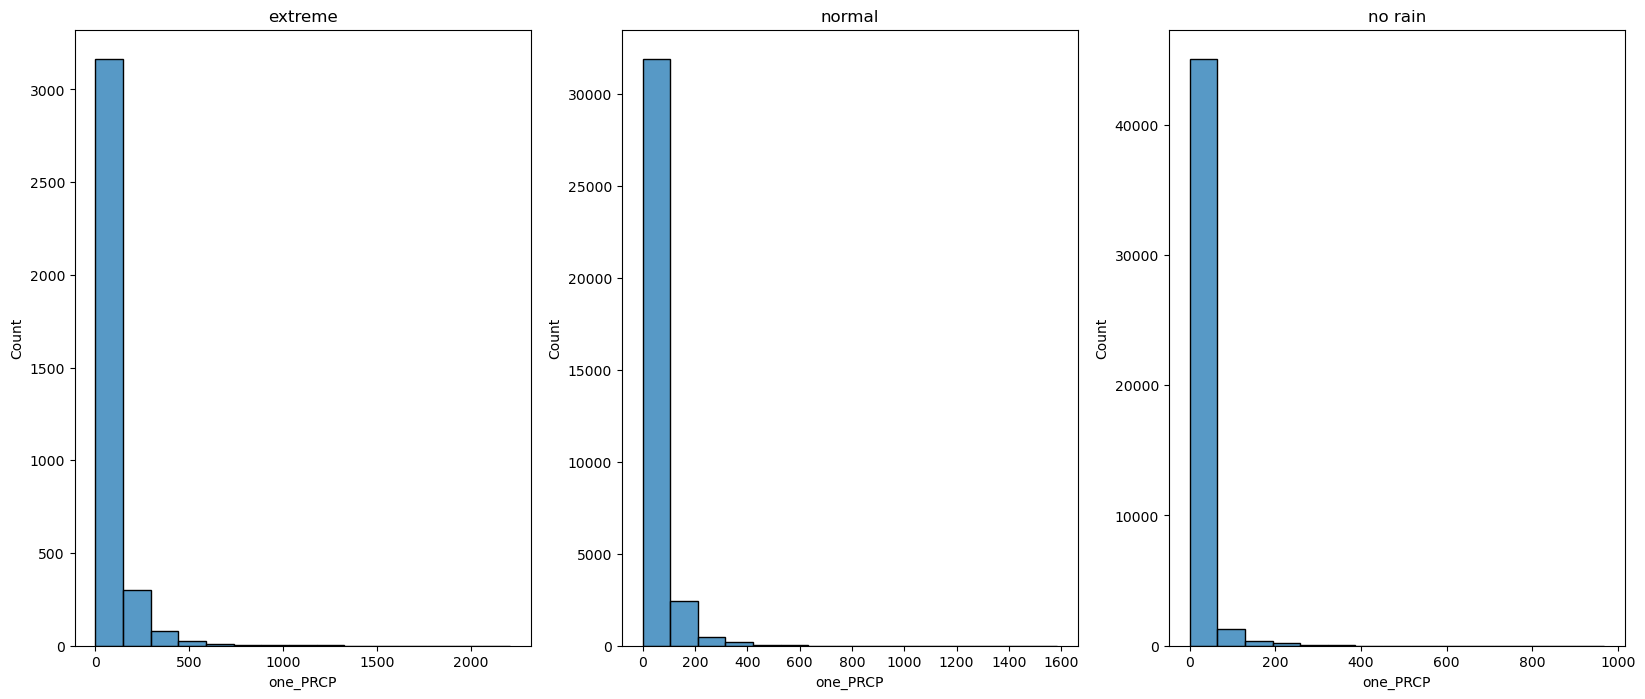

two_PRCP


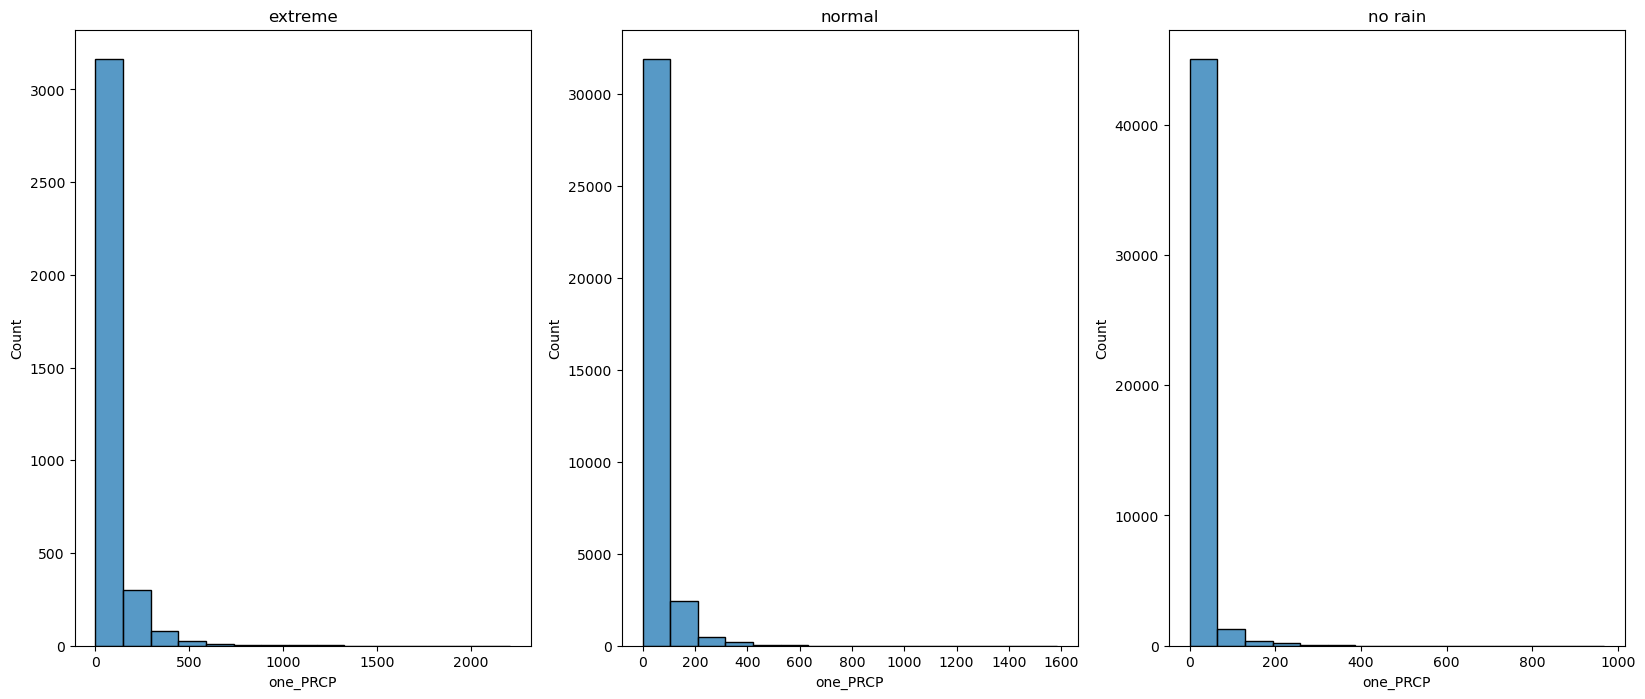

three_PRCP


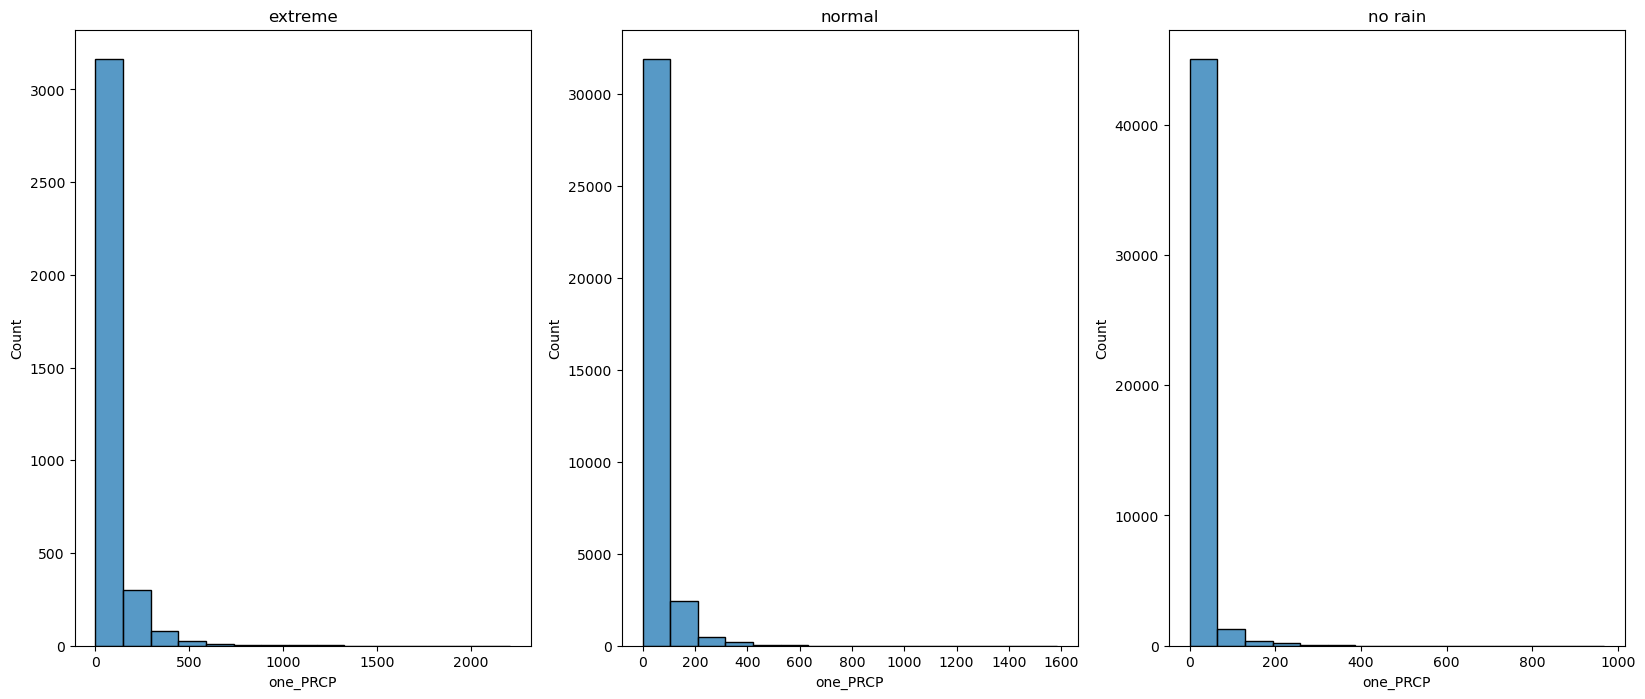

In [25]:
for lag in prcp_list:
    print(lag)
    fig, axis = plt.subplots(1,3, figsize=(20,8))
    for index, dataframe in enumerate(df_list):
        sns.histplot(data=dataframe, x="one_PRCP", bins = 15, ax = axis[index])
        axis[index].set_title(df_names[index])
    plt.show()

Let us examine correlation between lags and label to see what would indicate the lable and extreme rainfall. Because the label in the last dataset is always zero, the correlation is undefined.

In [26]:
for lag in prcp_list:
    print(lag)
    for index, dataframe in enumerate(df_list):
        print(dataframe[lag].corr(dataframe["label"]))

one_PRCP
0.16628323611952264
0.1492121749905781
nan
two_PRCP
0.01958249762013444
0.09668808171960531
nan
three_PRCP
-0.015051752281609987
0.08178267684444256
nan


Let us try to examine the patterns of the lags for each of the different categories. We will do so through clustering.

In [27]:
all_df = pd.concat(df_list, axis=0)
all_df.head()

,StationId,Date,label,latitude,longitude,maxTemp,minTemp,avgPrcp,cluster_label,one_PRCP,two_PRCP,three_PRCP,class_label
0,UKE00105926,2016-02-17,128,50.783901,0.9839,202.898876,15.786517,17.048203,2,0,0,0,2
1,UKE00105926,2016-03-08,150,50.783901,0.9839,202.898876,15.786517,17.048203,2,0,10,0,2
2,UKE00105926,2016-06-16,125,50.783901,0.9839,202.898876,15.786517,17.048203,2,26,1,5,2
3,UKE00105926,2016-06-17,139,50.783901,0.9839,202.898876,15.786517,17.048203,2,125,26,1,2
4,UKE00105926,2016-06-22,328,50.783901,0.9839,202.898876,15.786517,17.048203,2,1,32,105,2


Interestingly, aside from the cluster size of 2. There are no cluster centers that are strictly high. There is always a cluster that is low and there usually is a cluster that is very high at one_PRCP (lag of 1) and then drops off. And a cluster that has a low one_PRCP nad then jumps

In [28]:
cluster_sizes = [2, 3, 4, 5, 6, 7]
for k in cluster_sizes:
    print("cluster size:", str(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(all_df[["one_PRCP", "two_PRCP", "three_PRCP"]])
    print("CENTROIDS --------------------------------------")
    print(kmeans.cluster_centers_)
    prediction = kmeans.predict(all_df[["one_PRCP", "two_PRCP", "three_PRCP"]])
    silhouette_avg = silhouette_score(all_df[["one_PRCP", "two_PRCP", "three_PRCP"]], prediction)
    print("The average silhouette_score is :", silhouette_avg)

cluster size: 2
CENTROIDS --------------------------------------
[[ 98.81651754 114.04278515 106.71809112]
 [ 11.79813775  10.36722911  11.54420874]]
The average silhouette_score is : 0.703274815306107
cluster size: 3
CENTROIDS --------------------------------------
[[135.2388619  123.60083276  33.76960444]
 [ 10.20701344  10.3035659   10.571271  ]
 [ 29.59924027  57.11989554 210.39814815]]
The average silhouette_score is : 0.7025651883519228
cluster size: 4
CENTROIDS --------------------------------------
[[ 10.0302355    9.71090788  10.3796899 ]
 [204.75219904  42.25157075  27.8421714 ]
 [ 45.32861328 201.39501953  45.0078125 ]
 [ 29.14990234  46.26025391 209.09179688]]
The average silhouette_score is : 0.7115833636131444
cluster size: 5
CENTROIDS --------------------------------------
[[ 21.90025714  31.86398701 115.88645284]
 [207.99347088  42.54087229  26.35100548]
 [ 46.57630794 209.33640553  41.51070751]
 [ 51.71769815  98.06840391 380.70141151]
 [  9.72670594   9.0979237    6.4

We can see that the best silhoutte score is reached at cluster size = 4. And afterwards, decreases significantly. Therefore, we will continue our examination on k = 4

Now we will assign our sample data the clusters and try to understand the new clusterings relationship to the target variable:

In [29]:
kmeans_stats = KMeans(n_clusters=4, random_state=0).fit(all_df[["one_PRCP", "two_PRCP", "three_PRCP"]])
all_df["extreme_cluster"] = kmeans.predict(all_df[["one_PRCP", "two_PRCP", "three_PRCP"]])
kmeans_stats.cluster_centers_

array([[ 10.0302355 ,   9.71090788,  10.3796899 ],
       [204.75219904,  42.25157075,  27.8421714 ],
       [ 45.32861328, 201.39501953,  45.0078125 ],
       [ 29.14990234,  46.26025391, 209.09179688]])

Let us check if there is a connection between the pattern label based on the lags and the classification label

In [39]:
for i in range(4):
    print("cluster: " + str(i))
    ext_class_rel = pd.concat([all_df[all_df["extreme_cluster"] == i]["class_label"].value_counts(), 
                     all_df[all_df["extreme_cluster"] == i]["class_label"].value_counts(normalize=True)], axis=1)
    ext_class_rel.columns = ["category (#)", "category (%)"]
    print(ext_class_rel)

cluster: 0
   category (#)  category (%)
0         39810      0.608790
1         23597      0.360855
2          1985      0.030355
cluster: 1
   category (#)  category (%)
1          3267      0.548062
0          2330      0.390874
2           364      0.061064
cluster: 2
   category (#)  category (%)
1          3127      0.513212
0          2673      0.438700
2           293      0.048088
cluster: 3
   category (#)  category (%)
1          3813      0.649353
0          1382      0.235354
2           677      0.115293


We can conclude that clusters are skewed towards the first cluster, which is numerically the largest. However, cluster 3 is much more likely to be intense rain. Therefore, this is weak indicator and will be used in the model.

Let us look for a connection between the original clustering based on average percipitation, maximum temperature and minimum temperature to category

In [40]:
for i in range(3):
    print("original cluster: " + str(i))
    ext_class_rel = pd.concat([all_df[all_df["cluster_label"] == i]["class_label"].value_counts(), 
                     all_df[all_df["cluster_label"] == i]["class_label"].value_counts(normalize=True)], axis=1)
    ext_class_rel.columns = ["category (#)", "category (%)"]
    print(ext_class_rel)

original cluster: 0
   category (#)  category (%)
0          9944      0.653093
1          4928      0.323657
2           354      0.023250
original cluster: 1
   category (#)  category (%)
0         30538      0.599266
1         17924      0.351734
2          2497      0.049000
original cluster: 2
   category (#)  category (%)
1         12252      0.625900
0          6582      0.336245
2           741      0.037854


The proportions are essentially equal, therefore this is not indicative of anything and will be ignored.

Let us examine the parameter of time: via month and year

In [52]:
all_df["month"] = pd.DatetimeIndex(all_df['Date']).month
all_df["year"] = pd.DatetimeIndex(all_df['Date']).year
all_df.head()

,StationId,Date,label,latitude,longitude,maxTemp,minTemp,avgPrcp,cluster_label,one_PRCP,two_PRCP,three_PRCP,class_label,extreme_cluster,month,year
0,UKE00105926,2016-02-17,128,50.783901,0.9839,202.898876,15.786517,17.048203,2,0,0,0,2,0,2,2016
1,UKE00105926,2016-03-08,150,50.783901,0.9839,202.898876,15.786517,17.048203,2,0,10,0,2,0,3,2016
2,UKE00105926,2016-06-16,125,50.783901,0.9839,202.898876,15.786517,17.048203,2,26,1,5,2,0,6,2016
3,UKE00105926,2016-06-17,139,50.783901,0.9839,202.898876,15.786517,17.048203,2,125,26,1,2,3,6,2016
4,UKE00105926,2016-06-22,328,50.783901,0.9839,202.898876,15.786517,17.048203,2,1,32,105,2,2,6,2016


In [53]:
month_percent_list=[]
month_amount_list = []
for year in range(2016, 2021):
    for month in range(1,13):
        month_percent_list.append(all_df[(all_df["month"] == month) & (all_df["year"] == year)]["class_label"].value_counts(normalize=True))
        month_amount_list.append(all_df[(all_df["month"] == month) & (all_df["year"] == year)]["class_label"].value_counts())

In [68]:
month_percent_df = pd.concat(month_percent_list, axis=1)
month_percent_df.columns = pd.date_range("2016-01-01", periods=60, freq="M")
month_amount_df = pd.concat(month_amount_list, axis=1)
month_amount_df.columns = pd.date_range("2016-01-01", periods=60, freq="M")

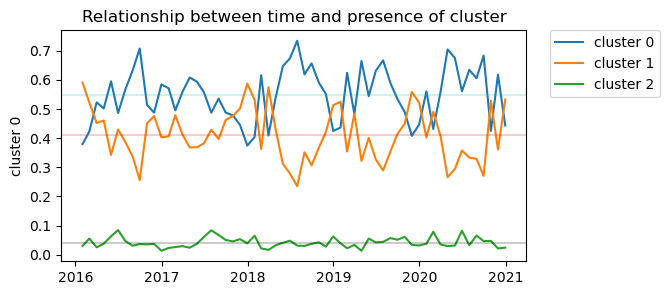

In [76]:
temp = month_percent_df.transpose()
temp.columns = ["cluster 0", "cluster 1", "cluster 2"]
fig, ax = plt.subplots()
sns.lineplot(x = temp.index, y = "cluster " + str(0), data=temp, label = "cluster " + str(0),ax=ax)
sns.lineplot(x = temp.index, y = "cluster " + str(1), data=temp, label = "cluster " + str(1),ax=ax)
sns.lineplot(x = temp.index, y = "cluster " + str(2), data=temp, label = "cluster " + str(2),ax=ax)
zero_mean = temp["cluster 0"].mean()
one_mean = temp["cluster 1"].mean()
two_mean = temp["cluster 2"].mean()
ax.axhline(y = zero_mean, color = 'c', linestyle = '-', alpha = 0.2)
ax.axhline(y = one_mean, color = 'r', linestyle = '-', alpha = 0.2)
ax.axhline(y = two_mean, color = 'k', linestyle = '-', alpha = 0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Relationship between time and presence of cluster")
plt.show()

Above we see that as time goes on, more time is spent on days with no rain (blue line is dominant) then normal rain. The amount of days spent in extreme rain is relatively stable with peaks usually taking place in the middle of the year.
We will also use year and month as predictors for our model.

Let us examine if there is a relationship between average precipitation at that location and extreme precipitation. As we saw earlier precipitation is distributed exponentially. Therefore, we will check both on normal and log scale.

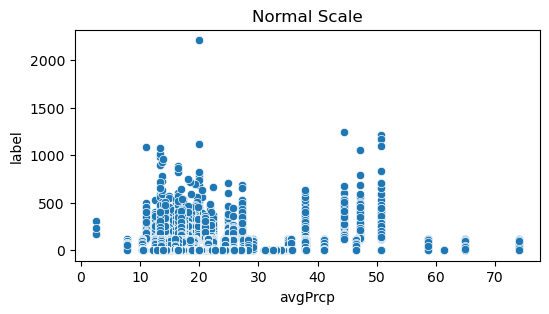

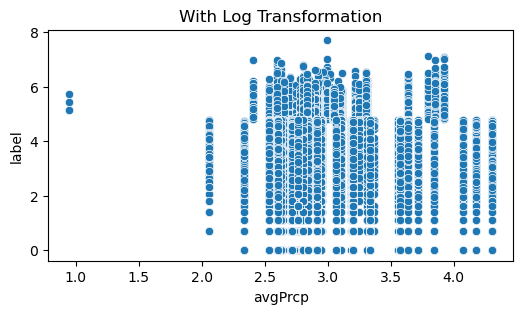

In [88]:
import numpy as np
sns.scatterplot(x="avgPrcp", y="label", data=all_df)
plt.title("Normal Scale")
plt.show()
sns.scatterplot(x="avgPrcp", y="label", data=all_df[["avgPrcp", "label"]].apply(np.log))
plt.title("With Log Transformation")
plt.show()

There seems to be no concrete relationship. Therefore, we will not include it in our model. (The classification which is a result of "label" will also clearly not have a relationship.)

In conclusion, in the sample set we have found a correlation between time (month, year), lags (the precipitation of the past three days) and the clusters based on the precipitation of the last three days to the target variable. Therefore, using them we will create our models features.

In [ ]:
PREPARE MODEL IN SPARK

We will now add to the population (non-sample) dataframe the columns of month, year and clustering

In [121]:
assembler1 = VectorAssembler(
    inputCols=["one_PRCP", "two_PRCP", "three_PRCP"],
    outputCol="features")
cluster_features_df = assembler1.transform(classified_df)

In [122]:
kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(cluster_features_df)
clustered_df = model.transform(cluster_features_df)

In [123]:
time_clustered_df = clustered_df.withColumn("month", F.month(F.col("date"))).withColumn("year", F.year(F.col("date"))).drop("features")

In [124]:
encoder = OneHotEncoder(inputCols=["prediction", "month", "year"],
                        outputCols=["encoded_month", "encoded_cluster", "encoded_year"])

assembler2 = VectorAssembler(
    inputCols=["encoded_cluster", "encoded_month", "encoded_year", "one_PRCP", "two_PRCP", "three_PRCP"],
    outputCol="features")

model = encoder.fit(time_clustered_df)
encoded = model.transform(time_clustered_df)
features_df = assembler2.transform(encoded)

(trainingData, testData) = features_df.drop("prediction", "month", "year").randomSplit([0.7, 0.3])

In [ ]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="class_label", predictionCol="prediction",
                                              metricName="f1")

MODEL SELECTION:

We will establish random forest as a baseline because it assumes nothing on the data.

In [101]:
from pyspark.ml.classification import RandomForestClassifier
for amount in [10, 50, 100]:
    rf = RandomForestClassifier(labelCol="class_label", numTrees = amount)
    rfmodel = rf.fit(trainingData)
    rfpredictions = rfmodel.transform(testData)
    rff1 = evaluator.evaluate(rfpredictions)
    print("Test set f1 = " + str(rff1))

Test set f1 = 0.3796796566687662
Test set f1 = 0.3796796566687662
Test set f1 = 0.3796796566687662


Random Forest provides a slightly above random baseline prediction. Changing the hyperparameters does not affect at all the predictive power of the model

We propose that Naive Bayes with Laplace smoothing is an appropriate model (explained in PDF). Laplace smoothing is important because it is conceivable that in a particular month there is no label. For example, there was never an extreme amount of water in the middle of summer.

In [103]:
for parameter in [0.1, 0.5, 1.0, 1.5, 4]:  
    print("Smoothing parameter: " + str(parameter))
    # create the model and set its parameters
    nb = NaiveBayes(smoothing=parameter, modelType="multinomial", labelCol="class_label")

    # train the model
    nbmodel = nb.fit(trainingData)

    # select example rows to display.
    nbpredictions = nbmodel.transform(testData)
    nbf1 = evaluator.evaluate(nbpredictions)
    print("Test set f1 = " + str(nbf1))

Smoothing parameter: 0.1
Test set f1 = 0.5057659136730239
Smoothing parameter: 0.5
Test set f1 = 0.5058345138237277
Smoothing parameter: 1.0


Exception ignored in: <function JavaWrapper.__del__ at 0x0000023789F9DC18>
Traceback (most recent call last):
  File "C:\BigDataLocalSetup\spark\python\pyspark\ml\wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RandomForestClassifier' object has no attribute '_java_obj'


Test set f1 = 0.5059024394332863
Smoothing parameter: 1.5
Test set f1 = 0.5060010240632339
Smoothing parameter: 4
Test set f1 = 0.5064734910824961


We see that this models predictive power is much better than a random guess (0.33) and better than our baseline (0.37). Therefore, we propose as our model Naive Bayes with a smoothing value of 1.

In [126]:
nb = NaiveBayes(smoothing=1, modelType="multinomial", labelCol="class_label")

# train the model
nbmodel = nb.fit(trainingData)

# select example rows to display.
nbpredictions = nbmodel.transform(testData)
nbf1 = evaluator.evaluate(nbpredictions)
print("Test set f1 = " + str(nbf1))

Test set f1 = 0.5049401650330516
